# Single-cell kymograph maker
This notebook is for making kymographs focused on a single apoptotic scribble cell scanning over all cells (wild-type and scribble)

In [1]:
import btrack
print("version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random
from tqdm import tqdm
import timeit ## can remove after assessing speed of different methods

version no.: 0.4.0


In [2]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(find_apoptosis_time(target_track, index = False)) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame) ## t.index provides the index of that frame
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def euc_dist(target_track, other_track, frame, apop_index):
    try:
        idx0 = apop_index ##target_track.t.index(apop_time) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame) ## t.index provides the index of that frame
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def euc_dist_mito(target_track, other_track, apop_index):
    idx0 = apop_index ##target_track.t.index(apop_time) ## could also do just ## apop_index
    idx1 = -1 ## t[-1] is the final frame, ie the frame of mitosis
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def find_apoptosis_time(target_track, index): ### if index is set to True then the index of the apoptotic time (wrt target_track) is returned
    try:
        if target_track.label[0] == 'APOPTOSIS': ## if the first classification is apoptosis then thats a duff track
            print("False apoptosis Scr ID:", target_track.ID)
            apop_index = apop_time = False
            if index == True: 
                return apop_index
            else: 
                return apop_time
        else: 
            for i, j in enumerate(target_track.label):
                if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
                    apop_index = i
                    break
            apop_time = target_track.t[apop_index]
            if index == True: 
                return apop_index
            else: 
                return apop_time
    except: 
        print("False apoptosis Scr ID:", target_track.ID)
        apop_index = apop_time = False
        if index == True: 
            return apop_index
        else: 
            return apop_time
    
def kymo_labels(num_bins, label_freq):
    radial_bin = radius / num_bins
    temporal_bin = t_range*2 / num_bins
#     print("Radius, time_range:", radius,",", (t_range*2))
#     print("Size radial bin:", radial_bin)
#     print("Size temporal bin:", temporal_bin)
#     print("No. bins:",num_bins)

    ## label frequence, ie num labels per bin
    #label_freq = 1

    ### generate labels for axis PIXELS/FRAMES
    xlocs = range(0, num_bins,label_freq) ## step of 2 to avoid crowding
    xlabels = []
    for m in range(int(-num_bins/2), int(num_bins/2),label_freq):
        xlabels.append(str(int((temporal_bin)*m)) + "," + str(int((temporal_bin)*m+temporal_bin)))
    #print("xlabels:",xlabels, type(xlabels))

    ylocs = range(0, num_bins, label_freq) ## step of 2 to avoid crowding
    ylabels = []
    for m in range(num_bins, 0, -label_freq):
        ylabels.append(str(int((radial_bin)*m)) + "," + str(int((radial_bin)*(m-1))))
    #print("ylabels:", ylabels, type(ylabels))
    
    return xlocs, xlabels, ylocs, ylabels

In [3]:
expt_path = '/home/nathan/data/kraken/h2b/giulia/GV0807/'
tracks_fn = os.path.join(expt_path, 'Pos3/Pos3_aligned/HDF/segmented.hdf5')
with btrack.dataio.HDF5FileHandler(tracks_fn, 'r', obj_type = "obj_type_1") as h:
    wt_tracks = h.tracks
with btrack.dataio.HDF5FileHandler(tracks_fn, 'r', obj_type = "obj_type_2") as h:
    scr_tracks = h.tracks
for i in range(len(scr_tracks)):
    scr_tracks[i].ID = -(scr_tracks[i].ID)
all_tracks = wt_tracks + scr_tracks ### negative IDs are scribble cells
print("Track information loaded and ordered according to cell type")

[INFO][2021/02/05 04:41:25 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/02/05 04:41:25 PM] Loading tracks/obj_type_1
[INFO][2021/02/05 04:41:29 PM] Loading objects/obj_type_1 (408973, 5) (388394 filtered: area>=100)
[INFO][2021/02/05 04:41:36 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/02/05 04:41:36 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/02/05 04:41:36 PM] Loading tracks/obj_type_2
[INFO][2021/02/05 04:41:36 PM] Loading objects/obj_type_2 (12115, 5) (8894 filtered: area>=100)
[INFO][2021/02/05 04:41:36 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type


# Calculate raw data for one cell (calculate neighbouring no. WT and WT mitoses)

In [5]:
print("Input cell type: 'WT' or 'Scr'")
cell_type = input()
print("Input cell ID")
cell_ID = int(input())

if cell_type == 'Scr':
    #index = [i for i, scr_apop in enumerate(scr_tracks) if scr_apop.ID == cell_ID][0]
    target_track = [scr_track for scr_track in scr_tracks if scr_track.ID == cell_ID][0]
    
    #target_track = scr_tracks[index]##### Show the first classification of each track
    ### if a scr cell is picked, the focal timepoint is its apoptosis
    apop_time = find_apoptosis_time(target_track, index = False)
    apop_index = find_apoptosis_time(target_track, index = True)
    
if cell_type == 'WT':
    index = [i for i, wt_track in enumerate(wt_tracks) if wt_track.ID == cell_ID][0]
    target_track = wt_tracks[index]##### Show the first classification of each track
    ### if a wt cell is picked, the focal time point is a random point in its track as this measurement will serve as a control
    apop_time = random.choice(target_track.t)
    apop_index = target_track.t.index(apop_time)

Input cell type: 'WT' or 'Scr'
Scr
Input cell ID
-17


In [6]:
target_track

,ID,t,x,y,z,parent,root,state,generation,dummy
0,-17,354,592.089050,1121.349365,0.000000,2,2,3,1,False
1,-17,355,599.770813,1122.750000,0.000000,2,2,3,1,False
2,-17,356,597.294983,1122.762573,0.000000,2,2,3,1,False
3,-17,357,595.140930,1121.939575,0.000000,2,2,3,1,False
4,-17,358,596.659119,1121.590942,0.000000,2,2,3,1,False
5,-17,359,598.070312,1123.187500,0.000000,2,2,3,1,False
6,-17,360,601.812317,1124.481201,0.000000,2,2,3,1,False
7,-17,361,606.079834,1126.327026,0.000000,2,2,3,1,False
8,-17,362,608.422485,1126.737915,0.000000,2,2,0,1,False
9,-17,363,610.502502,1127.165894,0.000000,2,2,0,1,False


#### Pick a temporal and radial range to scan over

In [7]:
radius = 400
t_range = 200 ### actual range will be twice this as it scans neg and pos

#### Scanning over every cell (both WT and Scr)

In [8]:
start = timeit.default_timer()
cells = [tuple(((any_cell.ID),
                  (round((euc_dist(target_track, any_cell, (apop_time+delta_t), apop_index)),2)),
                  ((apop_time + delta_t)))) 
           for delta_t in range(-t_range, t_range)
           for any_cell in all_tracks 
               if euc_dist(target_track, any_cell, apop_time + delta_t, apop_index)<radius
           ]
stop = timeit.default_timer()

print('Any cell counter calculation time: ', round((stop - start),2), 'seconds') 

Any cell counter calculation time:  86.71 seconds


In [9]:
cells

[(4, 304.86, 530),
 (131, 353.79, 530),
 (143, 391.88, 530),
 (144, 294.08, 530),
 (148, 128.37, 530),
 (154, 259.08, 530),
 (157, 137.47, 530),
 (217, 262.93, 530),
 (218, 347.46, 530),
 (239, 146.57, 530),
 (287, 240.55, 530),
 (288, 250.19, 530),
 (291, 364.15, 530),
 (308, 205.29, 530),
 (309, 232.36, 530),
 (310, 297.58, 530),
 (311, 263.67, 530),
 (315, 217.52, 530),
 (316, 142.47, 530),
 (317, 189.3, 530),
 (318, 105.79, 530),
 (330, 217.33, 530),
 (331, 187.53, 530),
 (335, 144.03, 530),
 (336, 165.52, 530),
 (340, 260.92, 530),
 (339, 295.14, 530),
 (341, 284.97, 530),
 (346, 280.16, 530),
 (345, 262.44, 530),
 (342, 316.72, 530),
 (352, 51.88, 530),
 (353, 48.66, 530),
 (367, 148.43, 530),
 (368, 96.26, 530),
 (369, 281.93, 530),
 (371, 250.45, 530),
 (372, 231.02, 530),
 (379, 399.59, 530),
 (380, 61.74, 530),
 (381, 45.97, 530),
 (383, 349.73, 530),
 (384, 383.12, 530),
 (389, 78.15, 530),
 (399, 176.96, 530),
 (403, 195.33, 530),
 (405, 176.0, 530),
 (407, 132.37, 530),
 (

#### Scanning over every cell for mitoses

In [8]:
start = timeit.default_timer()
### count number of mitoses
any_cell_mito = [tuple(((any_cell.ID),
                  (round((euc_dist_mito(target_track, any_cell, apop_index)),2)),
                  (any_cell.t[-1]),
                  (any_cell.label[-1]),
                  (any_cell.fate.name))) 
           for any_cell in all_tracks
            if 
            euc_dist_mito(target_track, any_cell, apop_index)<radius and ## within the full radial extent
            any_cell.fate.name == "DIVIDE" 
           ]
stop = timeit.default_timer()

print('Any cell mitosis cell counter calculation time: ', round((stop - start),2), 'seconds') 

Any cell mitosis cell counter calculation time:  0.19 seconds


In [ ]:
any_cell_mito

# Save measurments out

In [9]:
if cell_type == 'Scr':
    raw_numbers_path = os.path.join(expt_path, 'analysis/raw_numbers')
    no_cells_fn = os.path.join(raw_numbers_path,('no_cells_Scr_ID_' + str(cell_ID) + '.csv'))
    no_cells_mito_fn = os.path.join(raw_numbers_path, ('no_cells_mito_Scr_ID_' + str(cell_ID) + '.csv'))
if cell_type == 'WT':
    raw_numbers_path = os.path.join(expt_path, 'analysis/raw_numbers/controls')
    no_cells_fn = os.path.join(raw_numbers_path,('no_cells_WT_ID_' + str(cell_ID) + '.csv'))
    no_cells_mito_fn = os.path.join(raw_numbers_path, ('no_cells_mito_WT_ID_' + str(cell_ID) + '.csv'))


In [10]:
with open(no_cells_fn, 'w') as filehandle:
    filehandle.write('%s\n'%'ID, Distance, Frame')
    for listitem in cells:
        filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))

In [11]:
with open(no_cells_mito_fn, 'w') as filehandle:
    filehandle.write('%s\n'%'ID, Distance, Frame, State, Fate')
    for listitem in any_cell_mito:
        filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))

# Plotting data from one event into kymographs

#### Getting xy variables

In [14]:
all_cells_distance = [cells[i][1] for i in range(0,len(cells))]
all_cells_time = [cells[i][2] for i in range(0,len(cells))]

In [15]:
all_cells_distance_mito = [any_cell_mito[i][1] for i in range(0,len(any_cell_mito))]
all_cells_time_mito = [any_cell_mito[i][2] for i in range(0,len(any_cell_mito))]

# sanity checks -- need to save these out (after combining scr+wt count)

In [ ]:
plt.xticks(xlocs, time_bin_edges, rotation='vertical')

plt.plot(H_num_wt[:,19], c = 'b') ## across all distances, for the final time point
plt.plot(H_num_wt[19,:], color = 'r') ## across all time, for the biggest distance

#### Choose bin size for labels and to plot data into


In [ ]:
## choose bin size 
num_bins = 20

# Plotting all_cells

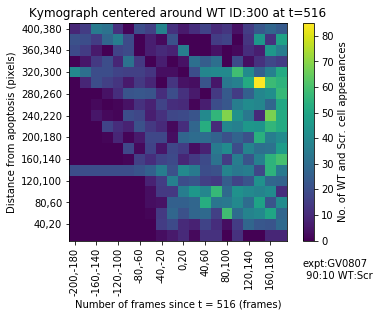

In [16]:
num_bins = 20
time_bin_edges = np.linspace((-(t_range)+apop_time),(t_range+apop_time), num_bins+1) ## 2dimensionalise
distance_bin_edges = np.linspace(0,radius, num_bins+1) ## 2dimensionalise
H_num_wt, x_autolabels, y_autolabels = np.histogram2d(all_cells_distance,all_cells_time, bins=[distance_bin_edges,time_bin_edges])
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
plt.ylabel("Distance from apoptosis (pixels)")
if cell_type == 'WT':
    title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
    no_all_cells_fn = os.path.join(expt_path, 'analysis/single_cell/controls',('no_all_cells_WT_ID_' + str(cell_ID) + '.png'))
if cell_type == 'Scr':
    title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
    no_all_cells_fn = os.path.join(expt_path, 'analysis/single_cell',('no_all_cells_Scr_ID_' + str(cell_ID) + '.png'))
plt.title(title)
plt.imshow(np.flipud(H_num_wt))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'No. of WT and Scr. cell appearances')#, ticks = list(range(0, int(round(np.amax(H))),30)))
expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
plt.text(num_bins+1,num_bins+3,expt_label)
plt.savefig(no_all_cells_fn, bbox_inches = 'tight', dpi = 300)
np.save(no_all_cells_fn[0:-4],H_num_wt)

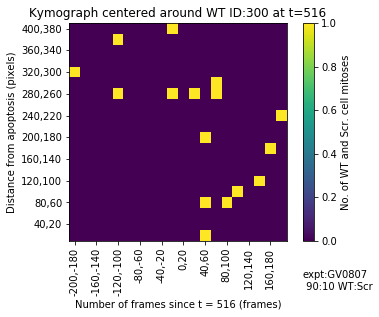

In [17]:
num_bins = 20
H_num_mito, x_autolabels, y_autolabels = np.histogram2d(all_cells_distance_mito,all_cells_time_mito, bins=[distance_bin_edges,time_bin_edges])
#H_mito = H_mito/bin_size ### because for every bin each cell could be counted for every frame present. Instead of reducing the count down to any instance of a cell, I want to preserve this cumulative count inside a single bin as a measure for how present that cell is in any bin. Ie a cell that is fully present will be counted fully, but only a fleeting presence of 1/20 frames will count as 1/20th of a fully presence. 
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
plt.ylabel("Distance from apoptosis (pixels)")
if cell_type == 'WT':
    title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
    no_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell/controls', ('no_all_cells_mito_WT_ID_' + str(cell_ID) + '.png'))
if cell_type == 'Scr':
    title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
    no_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell', ('no_all_cells_mito_Scr_ID_' + str(cell_ID) + '.png'))
plt.title(title)
plt.imshow(np.flipud(H_num_mito))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'No. of WT and Scr. cell mitoses')#, ticks = list(range(0, int(round(np.amax(H_mito))),2)))
expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
plt.text(num_bins+1,num_bins+4,expt_label)
plt.savefig(no_all_cells_mito_fn, bbox_inches = 'tight', dpi = 300)
np.save(no_all_cells_mito_fn[0:-4],H_num_mito)

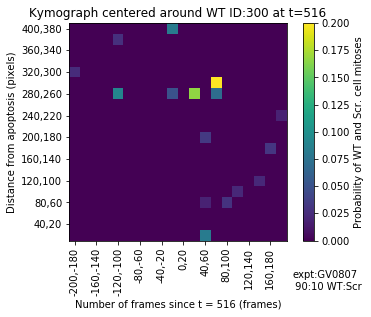

In [18]:
num_bins = 20
H_prob_mito = H_num_mito/(H_num_wt+1E-10)
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
plt.ylabel("Distance from apoptosis (pixels)")
if cell_type == 'WT':
    title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
    prob_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell/controls', ('prob_all_cells_mito_WT_ID_' + str(cell_ID) + '.png'))
if cell_type == 'Scr':
    title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
    prob_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell', ('prob_all_cells_mito_Scr_ID_' + str(cell_ID) + '.png'))
plt.title(title)
plt.imshow(np.flipud(H_prob_mito))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'Probability of WT and Scr. cell mitoses')
expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
plt.text(num_bins, num_bins+4,expt_label)
plt.savefig(prob_all_cells_mito_fn, bbox_inches = 'tight', dpi = 300)
np.save(prob_all_cells_mito_fn[0:-4],H_prob_mito)

# Merged cell for calculating over all cells




  0%|          | 0/103 [00:00<?, ?it/s]

Any cell counter calculation time:  37.04 seconds
Any cell mitosis cell counter calculation time:  0.15 seconds





  1%|          | 1/103 [00:38<1:05:07, 38.31s/it]

Any cell counter calculation time:  29.2 seconds
Any cell mitosis cell counter calculation time:  0.16 seconds





  2%|▏         | 2/103 [01:08<1:00:35, 35.99s/it]

Any cell counter calculation time:  30.59 seconds
Any cell mitosis cell counter calculation time:  0.2 seconds





  3%|▎         | 3/103 [01:40<57:59, 34.80s/it]  

Any cell counter calculation time:  31.46 seconds
Any cell mitosis cell counter calculation time:  0.17 seconds





  4%|▍         | 4/103 [02:13<56:28, 34.22s/it]

Any cell counter calculation time:  33.47 seconds
Any cell mitosis cell counter calculation time:  0.24 seconds





  5%|▍         | 5/103 [02:49<56:25, 34.54s/it]

Any cell counter calculation time:  32.29 seconds





  6%|▌         | 6/103 [03:22<55:26, 34.30s/it]

Any cell mitosis cell counter calculation time:  0.21 seconds
Any cell counter calculation time:  31.06 seconds
Any cell mitosis cell counter calculation time:  0.15 seconds





  7%|▋         | 7/103 [03:55<53:59, 33.74s/it]

Any cell counter calculation time:  35.94 seconds
Any cell mitosis cell counter calculation time:  0.25 seconds





  8%|▊         | 8/103 [04:32<55:11, 34.86s/it]

Any cell counter calculation time:  31.21 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





  9%|▊         | 9/103 [05:05<53:32, 34.17s/it]

Any cell counter calculation time:  35.09 seconds





 10%|▉         | 10/103 [05:41<54:05, 34.89s/it]

Any cell mitosis cell counter calculation time:  0.21 seconds
Any cell counter calculation time:  45.57 seconds
Any cell mitosis cell counter calculation time:  0.42 seconds





 11%|█         | 11/103 [06:29<59:13, 38.63s/it]

Any cell counter calculation time:  35.18 seconds
Any cell mitosis cell counter calculation time:  0.21 seconds





 12%|█▏        | 12/103 [07:05<57:42, 38.05s/it]

Any cell counter calculation time:  42.11 seconds
Any cell mitosis cell counter calculation time:  0.23 seconds





 14%|█▎        | 14/103 [07:49<49:13, 33.19s/it]

Any cell counter calculation time:  40.19 seconds
Any cell mitosis cell counter calculation time:  0.33 seconds





 15%|█▍        | 15/103 [08:31<52:35, 35.86s/it]

Any cell counter calculation time:  39.93 seconds
Any cell mitosis cell counter calculation time:  0.24 seconds





 17%|█▋        | 17/103 [09:13<44:53, 31.32s/it]

Any cell counter calculation time:  41.62 seconds
Any cell mitosis cell counter calculation time:  0.22 seconds





 17%|█▋        | 18/103 [09:56<49:25, 34.88s/it]

Any cell counter calculation time:  33.65 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 18%|█▊        | 19/103 [10:31<48:54, 34.93s/it]

Any cell counter calculation time:  34.18 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 19%|█▉        | 20/103 [11:06<48:35, 35.12s/it]

Any cell counter calculation time:  43.54 seconds
Any cell mitosis cell counter calculation time:  0.24 seconds





 20%|██        | 21/103 [11:52<52:07, 38.14s/it]

Any cell counter calculation time:  40.24 seconds





 21%|██▏       | 22/103 [12:33<52:56, 39.21s/it]

Any cell mitosis cell counter calculation time:  0.2 seconds
Any cell counter calculation time:  43.25 seconds
Any cell mitosis cell counter calculation time:  0.26 seconds





 22%|██▏       | 23/103 [13:18<54:33, 40.91s/it]

Any cell counter calculation time:  35.22 seconds
Any cell mitosis cell counter calculation time:  0.12 seconds





 23%|██▎       | 24/103 [13:55<52:17, 39.71s/it]

Any cell counter calculation time:  45.83 seconds
Any cell mitosis cell counter calculation time:  0.23 seconds





 24%|██▍       | 25/103 [14:43<54:38, 42.03s/it]

Any cell counter calculation time:  49.19 seconds
Any cell mitosis cell counter calculation time:  0.22 seconds





 25%|██▌       | 26/103 [15:33<57:17, 44.64s/it]

Any cell counter calculation time:  39.74 seconds
Any cell mitosis cell counter calculation time:  0.14 seconds





 26%|██▌       | 27/103 [16:14<55:13, 43.60s/it]

Any cell counter calculation time:  45.67 seconds
Any cell mitosis cell counter calculation time:  0.22 seconds





 27%|██▋       | 28/103 [17:02<55:51, 44.68s/it]

Any cell counter calculation time:  50.11 seconds
Any cell mitosis cell counter calculation time:  0.22 seconds





 28%|██▊       | 29/103 [17:53<57:42, 46.79s/it]

Any cell counter calculation time:  42.55 seconds
Any cell mitosis cell counter calculation time:  0.22 seconds





 29%|██▉       | 30/103 [18:38<55:57, 46.00s/it]

Any cell counter calculation time:  46.51 seconds





 30%|███       | 31/103 [19:26<55:55, 46.61s/it]

Any cell mitosis cell counter calculation time:  0.21 seconds
Any cell counter calculation time:  49.89 seconds
Any cell mitosis cell counter calculation time:  0.26 seconds





 32%|███▏      | 33/103 [20:17<47:04, 40.36s/it]

Any cell counter calculation time:  37.27 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 33%|███▎      | 34/103 [20:56<45:50, 39.86s/it]

Any cell counter calculation time:  45.98 seconds
Any cell mitosis cell counter calculation time:  0.25 seconds





 34%|███▍      | 35/103 [21:43<47:48, 42.19s/it]

Any cell counter calculation time:  53.08 seconds
Any cell mitosis cell counter calculation time:  0.26 seconds





 35%|███▍      | 36/103 [22:38<51:18, 45.95s/it]

Any cell counter calculation time:  39.9 seconds
Any cell mitosis cell counter calculation time:  0.12 seconds





 36%|███▌      | 37/103 [23:19<49:00, 44.55s/it]

Any cell counter calculation time:  46.1 seconds
Any cell mitosis cell counter calculation time:  0.22 seconds





 37%|███▋      | 38/103 [24:07<49:15, 45.48s/it]

Any cell counter calculation time:  48.75 seconds





 38%|███▊      | 39/103 [24:58<50:06, 46.97s/it]

Any cell mitosis cell counter calculation time:  0.21 seconds
Any cell counter calculation time:  47.47 seconds
Any cell mitosis cell counter calculation time:  0.19 seconds





 39%|███▉      | 40/103 [25:47<49:57, 47.58s/it]

Any cell counter calculation time:  43.18 seconds
Any cell mitosis cell counter calculation time:  0.17 seconds





 40%|███▉      | 41/103 [26:31<48:15, 46.70s/it]

Any cell counter calculation time:  42.27 seconds
Any cell mitosis cell counter calculation time:  0.15 seconds





 41%|████      | 42/103 [27:15<46:34, 45.81s/it]

Any cell counter calculation time:  49.86 seconds
Any cell mitosis cell counter calculation time:  0.29 seconds





 42%|████▏     | 43/103 [28:07<47:36, 47.61s/it]

Any cell counter calculation time:  50.69 seconds
Any cell mitosis cell counter calculation time:  0.24 seconds





 43%|████▎     | 44/103 [28:59<48:12, 49.02s/it]

Any cell counter calculation time:  42.27 seconds
Any cell mitosis cell counter calculation time:  0.14 seconds





 44%|████▎     | 45/103 [29:43<45:51, 47.43s/it]

Any cell counter calculation time:  41.13 seconds
Any cell mitosis cell counter calculation time:  0.13 seconds





 45%|████▍     | 46/103 [30:25<43:41, 45.98s/it]

Any cell counter calculation time:  39.47 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 46%|████▌     | 47/103 [31:06<41:28, 44.44s/it]

Any cell counter calculation time:  40.36 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 47%|████▋     | 48/103 [31:48<40:00, 43.65s/it]

Any cell counter calculation time:  41.69 seconds
Any cell mitosis cell counter calculation time:  0.13 seconds





 48%|████▊     | 49/103 [32:31<39:09, 43.51s/it]

Any cell counter calculation time:  47.18 seconds
Any cell mitosis cell counter calculation time:  0.24 seconds





 49%|████▊     | 50/103 [33:20<39:49, 45.09s/it]

Any cell counter calculation time:  49.54 seconds
Any cell mitosis cell counter calculation time:  0.21 seconds





 50%|████▉     | 51/103 [34:11<40:39, 46.91s/it]

Any cell counter calculation time:  43.47 seconds
Any cell mitosis cell counter calculation time:  0.18 seconds





 50%|█████     | 52/103 [34:56<39:22, 46.33s/it]

Any cell counter calculation time:  41.79 seconds
Any cell mitosis cell counter calculation time:  0.12 seconds





 51%|█████▏    | 53/103 [35:40<37:54, 45.49s/it]

Any cell counter calculation time:  41.46 seconds
Any cell mitosis cell counter calculation time:  0.12 seconds





 52%|█████▏    | 54/103 [36:23<36:30, 44.71s/it]

Any cell counter calculation time:  43.94 seconds
Any cell mitosis cell counter calculation time:  0.16 seconds





 53%|█████▎    | 55/103 [37:08<35:57, 44.95s/it]

Any cell counter calculation time:  49.16 seconds
Any cell mitosis cell counter calculation time:  0.21 seconds





 54%|█████▍    | 56/103 [37:59<36:33, 46.68s/it]

Any cell counter calculation time:  41.18 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 55%|█████▌    | 57/103 [38:41<34:50, 45.44s/it]

Any cell counter calculation time:  48.49 seconds
Any cell mitosis cell counter calculation time:  0.21 seconds





 56%|█████▋    | 58/103 [39:31<35:07, 46.82s/it]

Any cell counter calculation time:  41.57 seconds
Any cell mitosis cell counter calculation time:  0.23 seconds





 57%|█████▋    | 59/103 [40:15<33:31, 45.72s/it]

Any cell counter calculation time:  50.38 seconds
Any cell mitosis cell counter calculation time:  0.22 seconds





 58%|█████▊    | 60/103 [41:07<34:07, 47.62s/it]

Any cell counter calculation time:  42.73 seconds
Any cell mitosis cell counter calculation time:  0.16 seconds





 59%|█████▉    | 61/103 [41:51<32:40, 46.67s/it]

Any cell counter calculation time:  41.34 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 60%|██████    | 62/103 [42:34<31:05, 45.49s/it]

Any cell counter calculation time:  47.52 seconds





 61%|██████    | 63/103 [43:23<31:02, 46.57s/it]

Any cell mitosis cell counter calculation time:  0.21 seconds
Any cell counter calculation time:  40.93 seconds
Any cell mitosis cell counter calculation time:  0.1 seconds





 63%|██████▎   | 65/103 [44:05<24:40, 38.95s/it]

Any cell counter calculation time:  45.59 seconds
Any cell mitosis cell counter calculation time:  0.2 seconds





 65%|██████▌   | 67/103 [44:52<20:36, 34.34s/it]

Any cell counter calculation time:  40.44 seconds
Any cell mitosis cell counter calculation time:  0.1 seconds





 66%|██████▌   | 68/103 [45:34<21:20, 36.60s/it]

Any cell counter calculation time:  41.9 seconds
Any cell mitosis cell counter calculation time:  0.12 seconds





 67%|██████▋   | 69/103 [46:18<21:53, 38.64s/it]

Any cell counter calculation time:  39.64 seconds
Any cell mitosis cell counter calculation time:  0.1 seconds





 68%|██████▊   | 70/103 [46:59<21:38, 39.35s/it]

Any cell counter calculation time:  43.1 seconds
Any cell mitosis cell counter calculation time:  0.14 seconds





 69%|██████▉   | 71/103 [47:43<21:48, 40.90s/it]

Any cell counter calculation time:  41.51 seconds
Any cell mitosis cell counter calculation time:  0.13 seconds





 70%|██████▉   | 72/103 [48:26<21:27, 41.53s/it]

Any cell counter calculation time:  40.89 seconds
Any cell mitosis cell counter calculation time:  0.12 seconds





 71%|███████   | 73/103 [49:08<20:53, 41.78s/it]

Any cell counter calculation time:  46.72 seconds
Any cell mitosis cell counter calculation time:  0.21 seconds





 72%|███████▏  | 74/103 [49:57<21:08, 43.75s/it]

Any cell counter calculation time:  45.41 seconds





 73%|███████▎  | 75/103 [50:44<20:52, 44.72s/it]

Any cell mitosis cell counter calculation time:  0.21 seconds
Any cell counter calculation time:  39.74 seconds
Any cell mitosis cell counter calculation time:  0.21 seconds





 74%|███████▍  | 76/103 [51:25<19:39, 43.70s/it]

Any cell counter calculation time:  43.7 seconds
Any cell mitosis cell counter calculation time:  0.19 seconds





 75%|███████▍  | 77/103 [52:10<19:08, 44.17s/it]

Any cell counter calculation time:  42.42 seconds
Any cell mitosis cell counter calculation time:  0.2 seconds





 76%|███████▌  | 78/103 [52:54<18:22, 44.11s/it]

Any cell counter calculation time:  39.51 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 77%|███████▋  | 79/103 [53:35<17:16, 43.17s/it]

Any cell counter calculation time:  39.45 seconds
Any cell mitosis cell counter calculation time:  0.1 seconds





 78%|███████▊  | 80/103 [54:16<16:16, 42.48s/it]

Any cell counter calculation time:  40.03 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 79%|███████▊  | 81/103 [54:58<15:28, 42.19s/it]

Any cell counter calculation time:  40.69 seconds
Any cell mitosis cell counter calculation time:  0.16 seconds





 80%|███████▉  | 82/103 [55:40<14:45, 42.17s/it]

Any cell counter calculation time:  42.8 seconds
Any cell mitosis cell counter calculation time:  0.17 seconds





 81%|████████  | 83/103 [56:24<14:16, 42.82s/it]

Any cell counter calculation time:  40.09 seconds
Any cell mitosis cell counter calculation time:  0.15 seconds





 83%|████████▎ | 85/103 [57:06<10:51, 36.20s/it]

Any cell counter calculation time:  40.28 seconds
Any cell mitosis cell counter calculation time:  0.18 seconds





 84%|████████▍ | 87/103 [57:48<08:25, 31.61s/it]

Any cell counter calculation time:  39.06 seconds
Any cell mitosis cell counter calculation time:  0.15 seconds





 85%|████████▌ | 88/103 [58:28<08:34, 34.28s/it]

Any cell counter calculation time:  38.25 seconds
Any cell mitosis cell counter calculation time:  0.18 seconds





 86%|████████▋ | 89/103 [59:08<08:23, 35.93s/it]

Any cell counter calculation time:  39.09 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 87%|████████▋ | 90/103 [59:48<08:05, 37.32s/it]

Any cell counter calculation time:  38.64 seconds
Any cell mitosis cell counter calculation time:  0.12 seconds





 89%|████████▉ | 92/103 [1:00:29<05:53, 32.14s/it]

Any cell counter calculation time:  39.39 seconds
Any cell mitosis cell counter calculation time:  0.16 seconds





 90%|█████████ | 93/103 [1:01:10<05:48, 34.85s/it]

Any cell counter calculation time:  37.61 seconds
Any cell mitosis cell counter calculation time:  0.16 seconds





 91%|█████████▏| 94/103 [1:01:49<05:25, 36.13s/it]

Any cell counter calculation time:  39.37 seconds
Any cell mitosis cell counter calculation time:  0.15 seconds





 92%|█████████▏| 95/103 [1:02:30<05:00, 37.56s/it]

Any cell counter calculation time:  37.19 seconds
Any cell mitosis cell counter calculation time:  0.12 seconds





 93%|█████████▎| 96/103 [1:03:08<04:25, 37.88s/it]

Any cell counter calculation time:  37.24 seconds
Any cell mitosis cell counter calculation time:  0.16 seconds





 94%|█████████▍| 97/103 [1:03:47<03:48, 38.13s/it]

Any cell counter calculation time:  37.57 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 95%|█████████▌| 98/103 [1:04:26<03:11, 38.38s/it]

Any cell counter calculation time:  37.37 seconds
Any cell mitosis cell counter calculation time:  0.12 seconds





 96%|█████████▌| 99/103 [1:05:05<02:33, 38.50s/it]

Any cell counter calculation time:  36.92 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 97%|█████████▋| 100/103 [1:05:43<01:55, 38.44s/it]

Any cell counter calculation time:  37.26 seconds
Any cell mitosis cell counter calculation time:  0.12 seconds





 98%|█████████▊| 101/103 [1:06:22<01:17, 38.51s/it]

Any cell counter calculation time:  36.79 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





 99%|█████████▉| 102/103 [1:07:00<00:38, 38.49s/it]

Any cell counter calculation time:  36.8 seconds
Any cell mitosis cell counter calculation time:  0.11 seconds





100%|██████████| 103/103 [1:07:38<00:00, 39.41s/it]


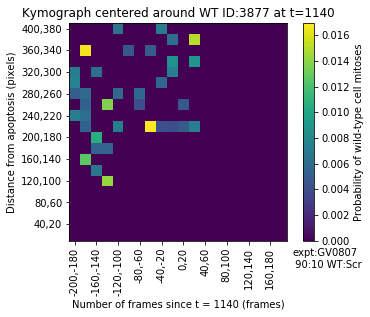

In [27]:
# print("Input cell type: 'WT' or 'Scr'")
# cell_type = input()
# print("Input cell ID")
# cell_ID = int(input())
cell_type = 'WT'
list_of_cell_IDs = range(1,3887,38)

for cell_ID in tqdm(list_of_cell_IDs): 
    try:
        if cell_type == 'Scr':
            #index = [i for i, scr_apop in enumerate(scr_tracks) if scr_apop.ID == cell_ID][0]
            target_track = [scr_track for scr_track in scr_tracks if scr_track.ID == cell_ID][0]

            #target_track = scr_tracks[index]##### Show the first classification of each track
            ### if a scr cell is picked, the focal timepoint is its apoptosis
            apop_time = find_apoptosis_time(target_track, index = False)
            apop_index = find_apoptosis_time(target_track, index = True)

        if cell_type == 'WT':
            index = [i for i, wt_track in enumerate(wt_tracks) if wt_track.ID == cell_ID][0]
            target_track = wt_tracks[index]##### Show the first classification of each track
            ### if a wt cell is picked, the focal time point is a random point in its track as this measurement will serve as a control
            apop_time = random.choice(target_track.t)
            apop_index = target_track.t.index(apop_time)

        radius = 400
        t_range = 200 ### actual range will be twice this as it scans neg and pos

        start = timeit.default_timer()
        cells = [tuple(((any_cell.ID),
                          (round((euc_dist(target_track, any_cell, (apop_time+delta_t), apop_index)),2)),
                          ((apop_time + delta_t)))) 
                   for delta_t in range(-t_range, t_range)
                   for any_cell in all_tracks 
                       if euc_dist(target_track, any_cell, apop_time + delta_t, apop_index)<radius
                   ]
        stop = timeit.default_timer()

        print('Any cell counter calculation time: ', round((stop - start),2), 'seconds') 

        start = timeit.default_timer()
        ### count number of mitoses
        any_cell_mito = [tuple(((any_cell.ID),
                          (round((euc_dist_mito(target_track, any_cell, apop_index)),2)),
                          (any_cell.t[-1]),
                          (any_cell.label[-1]),
                          (any_cell.fate.name))) 
                   for any_cell in all_tracks
                    if 
                    euc_dist_mito(target_track, any_cell, apop_index)<radius and ## within the full radial extent
                    any_cell.fate.name == "DIVIDE" 
                   ]
        stop = timeit.default_timer()

        print('Any cell mitosis cell counter calculation time: ', round((stop - start),2), 'seconds') 

        if cell_type == 'Scr':
            raw_numbers_path = os.path.join(expt_path, 'analysis/raw_numbers')
            no_cells_fn = os.path.join(raw_numbers_path,('no_cells_Scr_ID_' + str(cell_ID) + '.csv'))
            no_cells_mito_fn = os.path.join(raw_numbers_path, ('no_cells_mito_Scr_ID_' + str(cell_ID) + '.csv'))
        if cell_type == 'WT':
            raw_numbers_path = os.path.join(expt_path, 'analysis/raw_numbers/controls')
            no_cells_fn = os.path.join(raw_numbers_path,('no_cells_WT_ID_' + str(cell_ID) + '.csv'))
            no_cells_mito_fn = os.path.join(raw_numbers_path, ('no_cells_mito_WT_ID_' + str(cell_ID) + '.csv'))


        with open(no_cells_fn, 'w') as filehandle:
            filehandle.write('%s\n'%'ID, Distance, Frame')
            for listitem in cells:
                filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))

        with open(no_cells_mito_fn, 'w') as filehandle:
            filehandle.write('%s\n'%'ID, Distance, Frame, State, Fate')
            for listitem in any_cell_mito:
                filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))

        all_cells_distance = [cells[i][1] for i in range(0,len(cells))]
        all_cells_time = [cells[i][2] for i in range(0,len(cells))]

        all_cells_distance_mito = [any_cell_mito[i][1] for i in range(0,len(any_cell_mito))]
        all_cells_time_mito = [any_cell_mito[i][2] for i in range(0,len(any_cell_mito))]    

        num_bins = 20
        time_bin_edges = np.linspace((-(t_range)+apop_time),(t_range+apop_time), num_bins+1) ## 2dimensionalise
        distance_bin_edges = np.linspace(0,radius, num_bins+1) ## 2dimensionalise
        H_num_all_cells, x_autolabels, y_autolabels = np.histogram2d(all_cells_distance,all_cells_time, bins=[distance_bin_edges,time_bin_edges])
        xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
        plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
        plt.ylabel("Distance from apoptosis (pixels)")
        if cell_type == 'WT':
            title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
            no_all_cells_fn = os.path.join(expt_path, 'analysis/single_cell/controls',('no_all_cells_WT_ID_' + str(cell_ID) + '.png'))
        if cell_type == 'Scr':
            title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
            no_all_cells_fn = os.path.join(expt_path, 'analysis/single_cell',('no_all_cells_Scr_ID_' + str(cell_ID) + '.png'))
        plt.title(title)
        plt.imshow(np.flipud(H_num_all_cells))
        plt.yticks(ylocs, ylabels)
        plt.xticks(xlocs, xlabels, rotation='vertical')
        plt.colorbar(label = 'No. of WT and Scr. cell appearances')#, ticks = list(range(0, int(round(np.amax(H))),30)))
        expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
        plt.text(num_bins+1,num_bins+3,expt_label)
        plt.savefig(no_all_cells_fn, bbox_inches = 'tight', dpi = 300)
        np.save(no_all_cells_fn[0:-4],H_num_wt)
        plt.clf()

        num_bins = 20
        H_num_mito_all_cells, x_autolabels, y_autolabels = np.histogram2d(all_cells_distance_mito,all_cells_time_mito, bins=[distance_bin_edges,time_bin_edges])
        #H_mito = H_mito/bin_size ### because for every bin each cell could be counted for every frame present. Instead of reducing the count down to any instance of a cell, I want to preserve this cumulative count inside a single bin as a measure for how present that cell is in any bin. Ie a cell that is fully present will be counted fully, but only a fleeting presence of 1/20 frames will count as 1/20th of a fully presence. 
        xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
        plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
        plt.ylabel("Distance from apoptosis (pixels)")
        if cell_type == 'WT':
            title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
            no_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell/controls', ('no_all_cells_mito_WT_ID_' + str(cell_ID) + '.png'))
        if cell_type == 'Scr':
            title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
            no_all_cells_mito_fn = os.path.join(expt_path, 'analysis/single_cell', ('no_all_cells_mito_Scr_ID_' + str(cell_ID) + '.png'))
        plt.title(title)
        plt.imshow(np.flipud(H_num_mito_all_cells))
        plt.yticks(ylocs, ylabels)
        plt.xticks(xlocs, xlabels, rotation='vertical')
        plt.colorbar(label = 'No. of WT and Scr. cell mitoses')#, ticks = list(range(0, int(round(np.amax(H_mito))),2)))
        expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
        plt.text(num_bins+1,num_bins+4,expt_label)
        plt.savefig(no_all_cells_mito_fn, bbox_inches = 'tight', dpi = 300)
        np.save(no_all_cells_mito_fn[0:-4],H_num_mito_all_cells)
        plt.clf()

        num_bins = 20
        H_prob_mito_all_cells = H_num_mito_all_cells/(H_num_all_cells+1E-10)
        xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
        plt.xlabel("Number of frames since t = " + str(apop_time)+ ' (frames)')
        plt.ylabel("Distance from apoptosis (pixels)")
        if cell_type == 'WT':
            title = 'Kymograph centered around WT ID:' + str(target_track.ID) + ' at t=' +str(apop_time)##cell type and ID
            prob_wt_mito_fn = os.path.join(expt_path, 'analysis/single_cell/controls', ('prob_wt_mito_WT_ID_' + str(cell_ID) + '.png'))
        if cell_type == 'Scr':
            title = 'Kymograph centered around Scr ID:' + str(target_track.ID) + ' at t=' +str(apop_time) 
            prob_wt_mito_fn = os.path.join(expt_path, 'analysis/single_cell', ('prob_wt_mito_Scr_ID_' + str(cell_ID) + '.png'))
        plt.title(title)
        plt.imshow(np.flipud(H_prob_mito_all_cells))
        plt.yticks(ylocs, ylabels)
        plt.xticks(xlocs, xlabels, rotation='vertical')
        plt.colorbar(label = 'Probability of wild-type cell mitoses')
        expt_label = 'expt:' + expt_path[36:42] + '\n 90:10 WT:Scr'
        plt.text(num_bins, num_bins+2,expt_label)
        plt.savefig(prob_wt_mito_fn, bbox_inches = 'tight', dpi = 300)
        np.save(prob_wt_mito_fn[0:-4],H_prob_mito_all_cells)
    except:
        print(cell_type, "ID", cell_ID, "skipped")
        continue